# PCA - MNIST

En éste ejercicio vamos a aplicar PCA y K-means al digits dataset similar a MNIST, que incluye imágenes de dígitos de 8x8 píxeles. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize 
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits

In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Importamos el dataset

In [4]:
# Cargamos los datos de training
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [5]:
print('Formato de las etiquetas: {}'.format(y.shape))
print("Se tienen numeros de 0 al 9:")
print(np.unique(y))

Formato de las etiquetas: (1797,)
Se tienen numeros de 0 al 9:
[0 1 2 3 4 5 6 7 8 9]


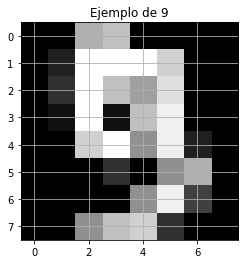

In [6]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y[9]))
plt.imshow(X[9, :].reshape((8, 8)), cmap='gray')

---

## Consignas

Siguiendo los ejemplos vistos en clase sobre los datasets de Human Activity Recognition y Fashion MNIST, realizar las siguientes consignas:

1. Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?
2. Graficar un scree plot (varianza contemplada en función del número de componentes considerados)
3. Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL].
4. Visualizar la imagen original vs. la reconstruida con los $m$ componentes del punto 1.
5. Graficar una matriz de correlación del dataset reducido.
6. Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.
7. Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?
8. Realizar un gráfico de inercia para obtener el número óptimo de clusters $k$.
9. Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?

In [7]:
from sklearn.preprocessing import StandardScaler

# If number of components is None, all components are kept
n_components = None
pca = PCA(n_components=None)
# Normalize the data
X_norm = normalize(X)
X_norm = StandardScaler(with_std=True).fit_transform(X)
# Apply PCA to the normalized dataset
X_new = pca.fit_transform(X_norm)
# Get the variance of each component
variance = pca.explained_variance_ratio_
cum_variance = np.cumsum(variance)
num_comp = cum_variance[cum_variance < 0.9].shape[0] + 1
print("El numero de componentes para obtener una varianza del 90% es: {}".format(num_comp))

El numero de componentes para obtener una varianza del 90% es: 31


Graficar un scree plot (varianza contemplada en función del número de componentes considerados)

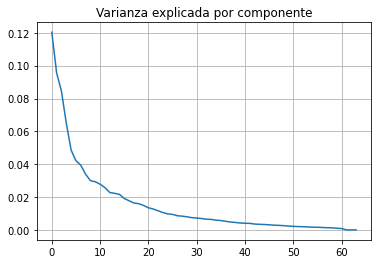

In [8]:
plt.plot(variance)
plt.title("Varianza explicada por componente")
plt.grid()

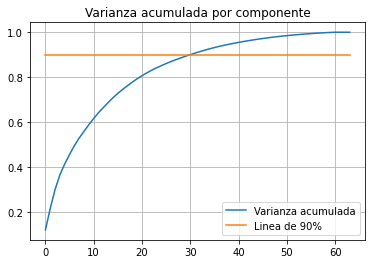

In [9]:
plt.plot(cum_variance, label="Varianza acumulada")
plt.plot([0.9 for i in range(int(cum_variance.shape[0]))], label="Linea de 90%")
plt.title("Varianza acumulada por componente")
plt.legend()
plt.grid()

Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL].

Primeras cinco componentes principales


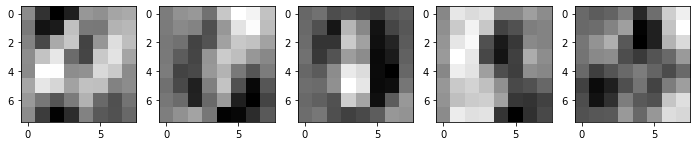

In [10]:
print("Primeras cinco componentes principales")
n_comp = 5
fig, axs = plt.subplots(1, n_comp, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.imshow(pca.components_[i].reshape((8, 8)), cmap='gray')

Pueden observarse las características principales de las imágenes que producen la mayor cantidad de infomación útil. 

Visualizar la imagen original vs. la reconstruida con los $m$ componentes del punto 1.

Imagenes originales


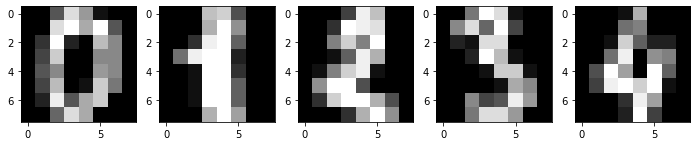

Imagenes reconstruidas


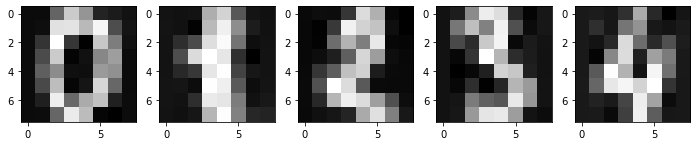

Diferencia entre las imágenes


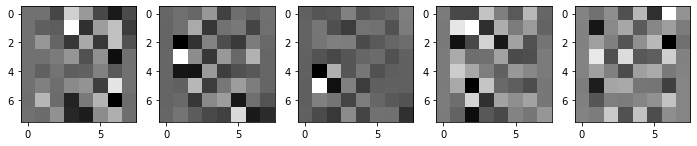

In [11]:
# Get PCA with number of components that explain the 90% of the variance
pca = PCA(n_components=num_comp)
# Also possible to do this
# pca = PCA(n_components=0.9)
X_new_reduc = pca.fit_transform(X)
X_recontructed = pca.inverse_transform(X_new_reduc)

diff = X - X_recontructed

print("Imagenes originales")
fig, axs = plt.subplots(1, 5, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.imshow(X[i, :].reshape((8, 8)), cmap='gray')
plt.show()

print("Imagenes reconstruidas")
fig, axs = plt.subplots(1, 5, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.imshow(X_recontructed[i, :].reshape((8, 8)), cmap='gray')
plt.show()

print("Diferencia entre las imágenes")
fig, axs = plt.subplots(1, 5, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.imshow(diff[i, :].reshape((8, 8)), cmap='gray')
plt.show()

Graficar una matriz de correlación del dataset reducido.

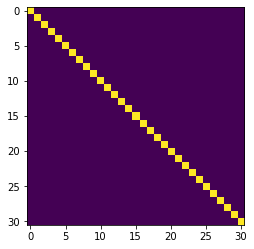

In [12]:
np.corrcoef(X_new_reduc).shape
plt.imshow(np.corrcoef(X_new_reduc.T))

Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.

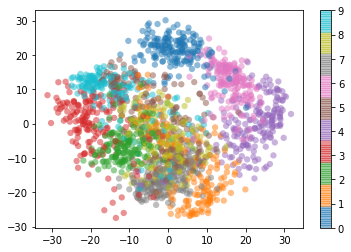

In [13]:
plt.scatter(X_new_reduc[:, 0], X_new_reduc[:, 1], c=y, edgecolor='none', alpha=0.5, s=40,
        cmap=plt.cm.get_cmap('tab10', 100))
plt.colorbar()

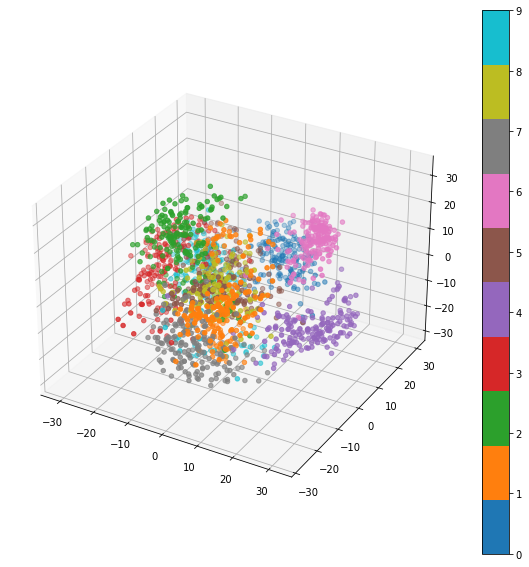

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_new_reduc[:, 0], X_new_reduc[:, 1], X_new_reduc[:, 2], c=y, cmap=plt.cm.get_cmap('tab10', 100))
fig.colorbar(p)

Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?

In [15]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=100)
kmeans.fit(X_new_reduc)

KMeans(n_clusters=10, n_init=100)

Clasificación real


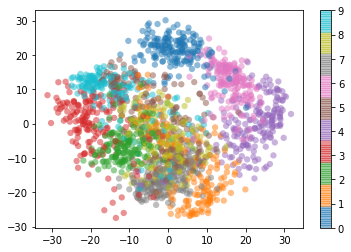

Clusterizacion usando kmeans


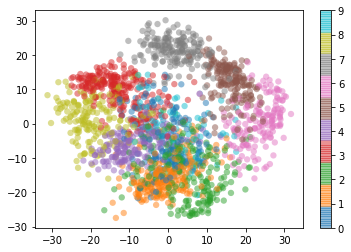

In [16]:
labels = kmeans.labels_

print("Clasificación real")
plt.scatter(X_new_reduc[:, 0], X_new_reduc[:, 1], c=y, edgecolor='none', alpha=0.5, s=40,
        cmap=plt.cm.get_cmap('tab10', 100))
plt.colorbar()
plt.show()

print("Clusterizacion usando kmeans")
plt.scatter(X_new_reduc[:, 0], X_new_reduc[:, 1], c=labels, edgecolor='none', alpha=0.5, s=40,
        cmap=plt.cm.get_cmap('tab10', 100))
plt.colorbar()
plt.show()


In [18]:
table = pd.crosstab(y, labels, margins=True)
table.index = [str(n) for n in range(10)] + ["all"]
table.columns = ["cluster" + str(n) for n in range(10)] + ["all"]
table

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,all
0,0,1,0,0,177,0,0,0,0,0,178
1,1,0,99,1,0,24,2,0,0,55,182
2,13,0,8,0,1,147,0,4,2,2,177
3,155,0,7,2,0,0,0,7,12,0,183
4,0,162,2,0,0,0,0,10,0,7,181
5,2,2,0,136,0,0,1,0,41,0,182
6,0,0,2,0,1,0,177,0,0,1,181
7,0,0,2,0,0,0,0,175,0,2,179
8,2,0,100,4,0,3,2,5,52,6,174
9,7,0,1,4,0,0,0,9,139,20,180


Realizar un gráfico de inercia para obtener el número óptimo de clusters $k$.

In [83]:
inertias = []
max_clusters = np.unique(y).shape[0] + 5
for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100)
    kmeans.fit(X_new_reduc)
    inertias.append(np.sqrt(kmeans.inertia_))
    

Grafico de inercia


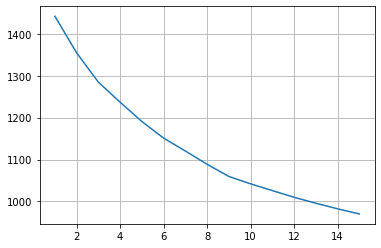

In [85]:
print("Grafico de inercia")
plt.plot(range(1, max_clusters + 1), inertias)
plt.grid()

In [86]:
for i in range(1, len(inertias) - 1):
    D = (inertias[i] - inertias[i + 1]) / (inertias[i - 1] - inertias[i]) 
    print("{}: {}". format(i, D))

1: 0.7994102898495701
2: 0.6839342471872891
3: 0.9655689846254136
4: 0.8566205379226987
5: 0.7790729381853856
6: 1.0249400333005296
7: 0.9229094865618891
8: 0.603623488581861
9: 0.9146967894192446
10: 0.9947129068262173
11: 0.8847870536237488
12: 0.9411946271417759
13: 0.916809179992219


El mejor número de clusters es 8

Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

Imagenes generadas


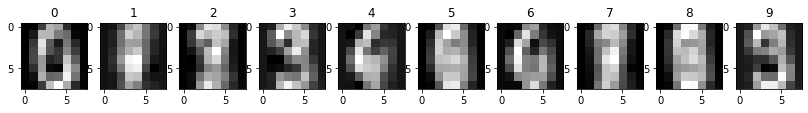

In [72]:
# Select positions to generate artificial values
digits = {
    0: [0, 25],
    1: [10, -20],
    2: [-10, -10],
    3: [-25, 0],
    4: [30, 0],
    5: [5, 0],
    6: [20, 15],
    7: [0, -15],
    8: [0, 0],
    9: [-20, 15], 
}

# data_reduced = np.dot(data - pca.mean_, pca.components_.T)
# data_original = np.dot(data_reduced, pca.components_) + pca.mean_

print("Imagenes generadas")
fig, axs = plt.subplots(1, 10, figsize=(14, 14))
for i, ax in enumerate(axs):
    gen_img = np.dot(digits[i], pca.components_[:2, :]) + pca.mean_
    ax.imshow(gen_img.reshape((8, 8)), cmap='gray')
    ax.set_title(str(i))
plt.show()